# Работающий прототип с веб камерой (детектирование лица + классификация эмоции)

Два режима: 
- фото - снимок с камеры с детектированием лица и определелением эмоции
- видео - детектирование и определение эмоции в режиме видео онлайн с камеры


In [2]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from copy import deepcopy
from torchvision import transforms
from PIL import Image

In [3]:
# pip install torchvision

In [4]:
# pip install opencv-python --upgrade --user

### Классифкатор

In [5]:
# загрузка модели
dict = {0 : 'anger', 1 : 'contempt', 2 : 'disgust',
        3 : 'fear', 4 : 'happy', 5 : 'neutral', 6 : 'sad', 7 : 'surprise', 8 : 'uncertain'}

model_dir = 'best.pt' # /home/khutsieva/projects/sk/ML_diplom/result/resnet152_2022_02_24-18_36/checkpoints/best.pt
model = torch.load(model_dir, map_location=torch.device('cpu'))

def classify_for_camera(img, model_emotion):
    # img - массив нампай
    img = Image.fromarray(img)
    data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    image_features = data_transforms(img)
    x = image_features
    logits = model_emotion(x[None, ...])
    preds = tf.nn.softmax(logits.cpu().detach().numpy())
    pred = np.argmax(preds[0])
    
    return dict[int(pred)]

### Детектор

In [6]:
# подключение камеры
cam = cv2.VideoCapture(0)
if not cam.isOpened():
    print("Не удалось открыть камеру")
else:
    print("Камера запущена")
# иницилизируем детектор:
face_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

def detect_for_camera(img):
    # img - массив нампай, emotion - название эмоции
    faces = face_detector.detectMultiScale(img, 1.3, 5)
    one_face = faces[0]
    x, y, w, h = one_face
    face_boundingbox = img[y:y + h, x:x + w]

    return face_boundingbox, x, y, w, h

Камера запущена


### Детектор + Классификатор

In [7]:
def summa_detector_classificator(img, x, y, w, h, emotion):
    # img - массив нампай
    rgb_image_with_boundingbox = deepcopy(img)
    rgb_image_with_boundingbox = cv2.rectangle(rgb_image_with_boundingbox, (x, y), (x + h, y + w), (0,255,0), 3)
    rgb_image_with_boundingbox_and_text = deepcopy(rgb_image_with_boundingbox)
    rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox_and_text, emotion, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return rgb_image_with_boundingbox_and_text

def predict(img, model):
    face_boundingbox, x, y, w, h = detect_for_camera(img) # отработка детектора
    emotion = classify_for_camera(face_boundingbox, model) # отработка классификатора
    res = summa_detector_classificator(img, x, y, w, h, emotion) # сумма
    return res

# Примеры работы

In [50]:
# классификатор
path = 'test1.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR2RGB
emotion = classify_for_camera(img, model) # отработка классификатора
print(emotion)

uncertain


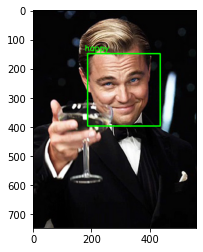

In [51]:
# классификатор + детектор
path = 'test1.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR2RGB
res = predict(img, model)
plt.imshow(res)
plt.show()

# Фото

In [7]:
# ДЛЯ ФОТО
def make_photo(model):
    cam = cv2.VideoCapture(0)
    k = 0
    while(True):
        k += 1
        ret, frame = cam.read()

        if k > 10:
            break
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # BGR2RGB
    try:
        res = predict(img, model)
    except:
        res = img
    plt.imshow(res)
    plt.show()
    cam.release()
    cv2.destroyAllWindows()

# Видео

In [30]:
# ДЛЯ ВИДЕО
def make_video(model):
    cam = cv2.VideoCapture(0)
    width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
    height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
    size = (width, height)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 4.0, size)
    k = 0
    while(True):
        k += 1
        ret, frame = cam.read()

        try:   
            res = predict(frame, model)
        except:
            res = frame
        cv2.imshow("facial emotion recognition", res)
        
        # запись видео
#         frame_ = cv2.flip(res, 0)
#         frame_= cv2.rotate(res, cv2.ROTATE_180)
        out.write(res)

    #     if k > 10:
    #         break
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break        
    cam.release()
    out.release()
    cv2.destroyAllWindows()

# ФОТО + ВИДЕО

In [31]:
class CAMERA():
    def __init__(self, model_dir):
        self.model = torch.load(model_dir, map_location=torch.device('cpu'))
        
    def predict_photo(self):
        make_photo(model)
    def predict_video(self):
        make_video(model)

In [32]:
camera = CAMERA(model_dir)

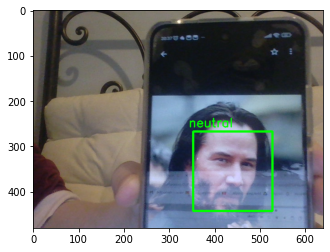

In [38]:
camera.predict_photo()

In [40]:
camera.predict_video()